# Exploration of Car Make and Violation Description Data from The City of Los Angeles Parking Citation Open Dataset

Based on [previous explorations](https://github.com/hackforla/lucky-parking/tree/citation-analysis/notebooks/exploratory) of the Los Angeles Parking Citation Open Dataset, it was found that parking citation violation types varied greatly by car make. This exploration will repeat that analysis and look at picking the best features for a model for users to interact with.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os
from pathlib import Path
import random
import seaborn as sns

# Load project directory
PROJECT_DIR = Path(os.path.abspath('../..'))

In [2]:
# Load already cleaned data from makefile command
# 20% sampled from raw dataset
# Only make and violation_description columns
df = pd.read_csv(PROJECT_DIR / 'data' / 'processed' / '2021-01-02_processed_02samp.csv', index_col=0)
df.head()

,make,violation_description
index,,
0,Chevrolet,NO STOPPING/STANDING
1,Honda,NO PARKING
2,Toyota,NO EVIDENCE OF REG
3,Honda,RED ZONE
4,Hyundai,NO EVIDENCE OF REG


In [3]:
# Examine missing data
df.isna().sum()/len(df)*100

make                     0.185939
violation_description    0.888983
dtype: float64

In [4]:
# Drop all missing data
df.dropna(inplace=True)

In [5]:
# Create table of violation ratio by make
make_vio_dict = {}
for make in df.make.value_counts().head(40).index:
  counts = df.loc[(df.make == make), 'violation_description'].value_counts()
  count_ratio = counts/counts.sum()
  make_vio_dict[make] = count_ratio.to_dict()
make_ratio = pd.DataFrame.from_dict(make_vio_dict).T.fillna(0)

In [6]:
# Show table of violation ratios
make_ratio.head(10).style.background_gradient(cmap='Blues').format("{:.3f}")

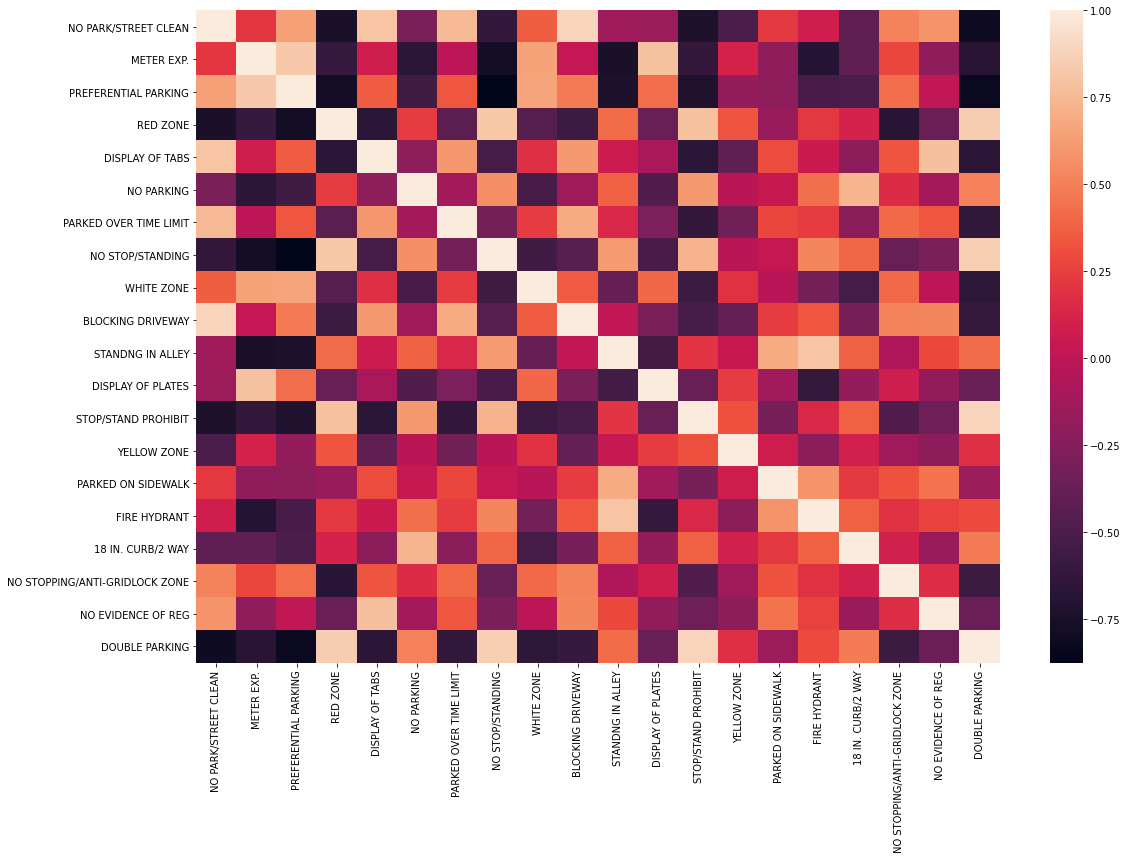

In [30]:
# Correlation heat map
plt.figure(figsize=(18,12))
sns.heatmap(make_ratio.iloc[:,:20].corr())
plt.show()

In [9]:
# Find principal component of violation ratio data using one component
pca = PCA(n_components=6)
make_pca = pd.DataFrame(data = pca.fit_transform(make_ratio)
             , columns = [f'Principal_Component_{n + 1}' for n in range(6)], index = make_ratio.index)
make_pca.head()

,Principal_Component_1,Principal_Component_2,Principal_Component_3,Principal_Component_4,Principal_Component_5,Principal_Component_6
Toyota,-0.055167,-0.043065,-0.012869,-0.017384,0.001551,0.009086
Honda,-0.054152,-0.052261,-0.010619,-0.007311,-0.002062,0.009455
Ford,-0.022620,-0.048478,0.002193,0.005117,-0.001114,0.000379
Nissan,-0.027387,-0.043421,-0.011723,-0.008799,0.000684,0.010982
Chevrolet,-0.013239,-0.046276,-0.000006,0.007753,0.000997,0.003121


[]

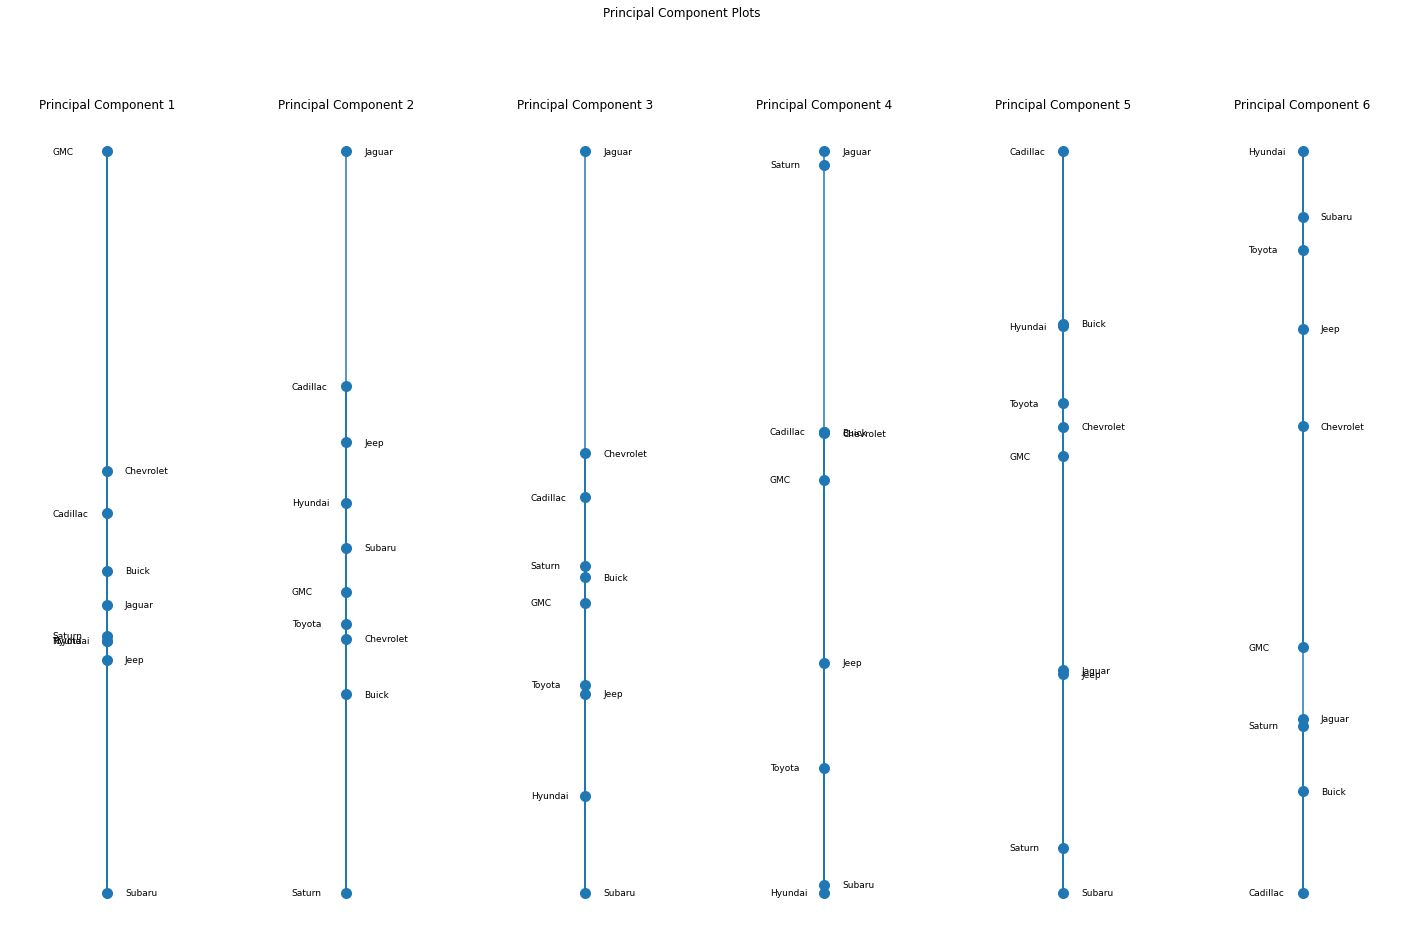

In [10]:
# Plot each make on each principal component
fig, axes = plt.subplots(1, 6, figsize=(25,15))
fig.suptitle('Principal Component Plots')

for ind, ax in enumerate(axes):
    subset = make_pca.iloc[::4, ind]
    # Add line return to Mercedes Benz
    subset.rename(index={'Mercedes Benz': 'Mercedes\nBenz'}, inplace=True)
    ax.plot(np.zeros(len(subset)), subset, marker='.', markersize=20)
    ax.axis('off')
    ax.set_title(f'Principal Component {ind+1}')
    for i, txt in enumerate(subset.index):
        if i%2 == 0:
            ax.annotate(txt, (-0.03, subset.iloc[i]), fontsize=9, va='center')
        else: 
            ax.annotate(txt, (0.01, subset.iloc[i]), fontsize=9, va='center')

plt.plot()

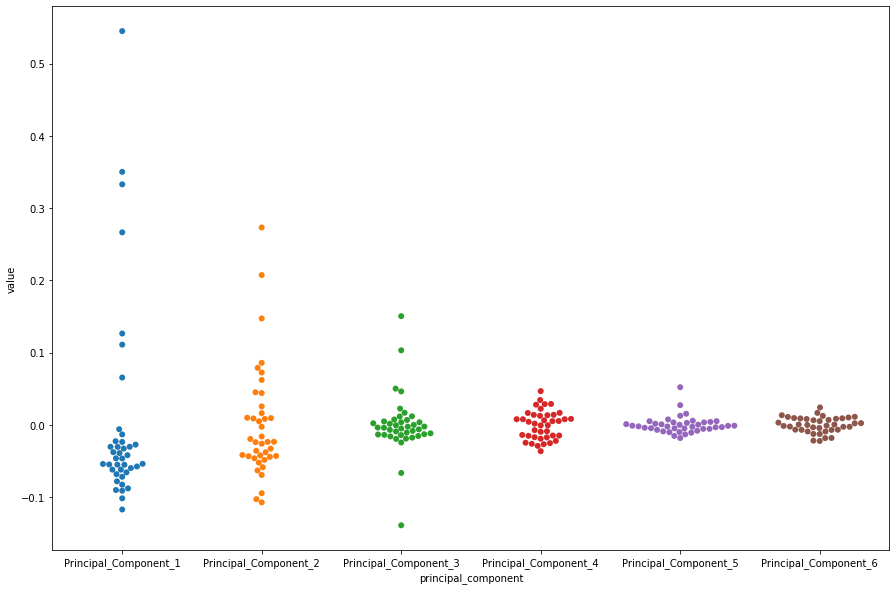

In [498]:
plt.figure(figsize=(15,10))
sns.swarmplot(x='principal_component' , y='value', data=pd.melt(make_pca.reset_index(), id_vars=['index'], var_name='principal_component'), size=6)
plt.show()

In [496]:
# Print explained variance ratio
pca.explained_variance_ratio_

array([0.69397733, 0.21524781, 0.06108238, 0.01408682, 0.00505293,
       0.00407453])

In [35]:
# Examine principal component weights
pca_components = pd.DataFrame(pca.components_, columns=make_ratio.columns, index=[f'PCA_{n + 1}' for n in range(6)])
pca_components.style.background_gradient(cmap='Blues').format("{:.3f}")

In [54]:
# Breakdown of the highest violation weight in each principal component
pd.DataFrame({'Major Violation Component': pca_components.apply(lambda x: x.idxmax(), axis=1).to_list() ,'Weight Fraction': pca_components.max(axis=1)})

,Major Violation Component,Weight Fraction
PCA_1,RED ZONE,0.708991
PCA_2,METER EXP.,0.684739
PCA_3,COMM VEH OVER TIME LIMIT,0.369242
PCA_4,DISPLAY OF PLATES,0.672108
PCA_5,COMM TRAILER/22 FT.,0.434576
PCA_6,DISPLAY OF PLATES,0.369216


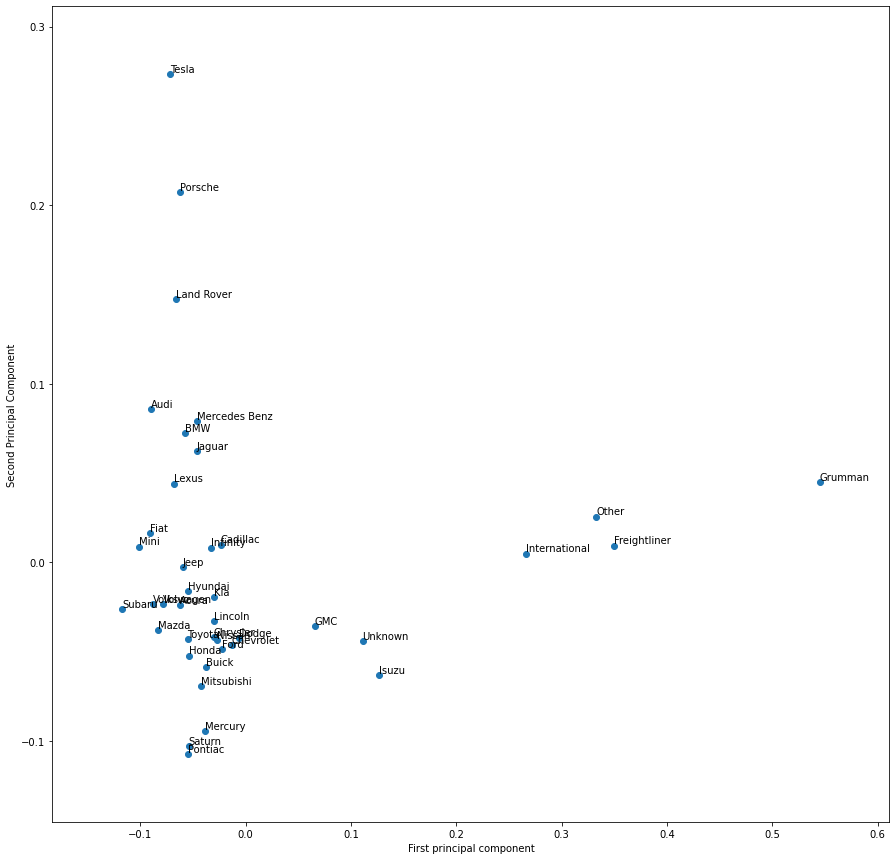

In [16]:
# PCA 2-component plot
plt.figure(figsize=(15,15))
plt.scatter(make_pca.iloc[:,0],make_pca.iloc[:,1])
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')
plt.margins(0.1)
for i, txt in enumerate(make_pca.index):
    plt.annotate(txt, (make_pca.iloc[i,0], make_pca.iloc[i,1]), fontsize=10, va='bottom')
plt.show()

In particular, principal component 2 has an interesting spread of data--according to the previous table, this component has meter expiration as the largest component and causes a very nice dispersion of car makes compared to the other components which are more bunched up. Also, the top offender is Tesla, followed by other luxury brand car makes and ends with some more affordable domestic car makes. This could reflect the parking behavior of people who drive luxury cars vs more affordable cars--people who drive luxury cars are not as affected by a fine caused by meter expiration.

In [62]:
pca_components.iloc[1,:14]

NO PARK/STREET CLEAN     -0.586933
METER EXP.                0.684739
PREFERENTIAL PARKING      0.094680
RED ZONE                 -0.028489
DISPLAY OF TABS          -0.112766
NO PARKING               -0.062982
PARKED OVER TIME LIMIT   -0.060313
NO STOP/STANDING         -0.044120
WHITE ZONE                0.011114
BLOCKING DRIVEWAY        -0.033732
STANDNG IN ALLEY         -0.036811
DISPLAY OF PLATES         0.381898
STOP/STAND PROHIBIT      -0.005183
YELLOW ZONE               0.013781
Name: PCA_2, dtype: float64

Here we can see that principal component 2 has its main component being meter expiration but street cleaning violations are negatively correlated, meaning car makes that score higher along this axis have less street sweeping and more meter expiration and display of plate violations.

If we were to build a model with the fewest amount of features, instead of just picking the highest weights we would pick the highest absolute value weights and throw out any other weights that are close to zero.

In [63]:
# Ratio of absolute values in principal component 2
pca_components.iloc[1].abs().sort_values(ascending=False).head(20)/sum(pca_components.iloc[1].abs())*100

METER EXP.                  27.748920
NO PARK/STREET CLEAN        23.785327
DISPLAY OF PLATES           15.476340
DISPLAY OF TABS              4.569814
PREFERENTIAL PARKING         3.836887
NO PARKING                   2.552341
PARKED OVER TIME LIMIT       2.444173
EXCEED 72HRS-ST              2.014230
NO STOP/STANDING             1.787973
NO EVIDENCE OF REG           1.717449
STANDNG IN ALLEY             1.491765
BLOCKING DRIVEWAY            1.366964
RED ZONE                     1.154531
FIRE HYDRANT                 0.911061
COMM VEH OVER TIME LIMIT     0.618552
YELLOW ZONE                  0.558487
OUTSIDE LINES/METER          0.510332
WHITE ZONE                   0.450402
PARKED ON SIDEWALK           0.384666
COMM TRAILER/22 FT.          0.355933
Name: PCA_2, dtype: float64